# Assignment 2

# Formalia:

Please read the [assignment overview page](https://laura.alessandretti.com/comsocsci2023/assignments.html) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Mar 28th at 23:59. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Assignment, Assignment 2)_. 

Remember to include in the first cell of your notebook:
* the link to your group's Git repository https://github.com/christian-kento-rasmussen/02467-Computational-Social-Science-projects
* group members' contributions

# Part 1: Mixing Patterns and Assortativity

Let's dig in and try to understand more about the network of Computational Social Scientists using more advanced features. If your network has more than one component, just work on the giant connected component (GCC) in the exercises below. For the exercises below, you shall use the network you built in [Week 4](https://github.com/lalessan/comsocsci2023/blob/main/lectures/Week4.ipynb).


> **Exercise 1: Mixing Patterns and Assortativity.** 
>
> * For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.
> * Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.
> * Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?
> * Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain? (__Hint__: See [this paper](https://nbviewer.org/github/suneman/socialgraphs2019/blob/master/lectures/Week5.ipynb), eq (2)). **Important**: here I do not want you to use the NetworkX implementation, but rather to implement your own version of the measure.    
> * Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.
> * _Optional:_ Estimate the gender of each author from their name, using the [World Gender Name Dictionary](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/MSEGSJ). Repeat the analysis above to study the assortativity of the network by gender rather than by field. What do you observe?


In [1]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import kstest
import pandas as pd

In [2]:
with open('/work/graphDataRemovedNotes.json', 'r') as openfile:
    # Reading from json file
    json_object = json.load(openfile)
    G = nx.node_link_graph(json_object)

largest_connected_component = max(nx.connected_components(G), key=len)

G = G.subgraph(largest_connected_component).copy()

print(G)

# node data example
#{'name': 'xxx xxx xx',
# 'top_field': 'xxxx xxxx',
# 'median_Citation_Count': x.x,
# 'earliest_Year_of_Publishing': xxxx,
# 'total_CSS_Papers': xx}

Graph with 5666 nodes and 14500 edges


### 1.1 For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.

In [3]:
# gets the top field of each node
node_fiels_dict = nx.get_node_attributes(G,'top_field')

# goes over all nodes and its neighbor's calculates the fractions of neighbors in the same field
def neighbor_same_field_frac(G, node_fiels_dict):
    node_adj_same_field_frac_list = []

    # loops over all nodes
    for node_id in G.nodes:
        # gets their top field
        node_field = node_fiels_dict.get(node_id)
         
        # gets neighbors top field
        neighbor_fields = [node_fiels_dict.get(key) for key in G.neighbors(node_id)]
        
        # Creates list of true and false if they are in same field
        same_field_list = [1 if node_field == neighbor_field else 0 for neighbor_field in neighbor_fields]

        # creates fraction
        node_adj_same_field_frac_list.append(sum(same_field_list)/len(same_field_list))
    
    # returns mean over all nodes
    return np.mean(node_adj_same_field_frac_list)

node_adj_same_field_frac = neighbor_same_field_frac(G, node_fiels_dict)
print(f"node_adj_same_field_frac_list: {node_adj_same_field_frac}")

node_adj_same_field_frac_list: 0.4667773353894598


The fraction of edges that connect to a node in the same top field is 0.47

### 1.2 Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?

In [4]:
def shuffle_node_fiels_dict(node_fiels_dict):
    """ Function that shuffles top fields in a dictionary
    """
    # gets all top fields
    top_fields = list(node_fiels_dict.values())

    # shuffles top_fields
    shuffled_top_field = random.sample(top_fields, len(node_fiels_dict))

    # create new dict
    node_fiels_dict = dict(zip(list(node_fiels_dict.keys()), shuffled_top_field))

    return node_fiels_dict

# number of samples
n = 200

# we shuffle the top_field and calculate the fraction 200 times
neighbor_same_field_frac_shuffled_list = []
for i in range(n):
    node_fiels_dict = shuffle_node_fiels_dict(node_fiels_dict)
    neighbor_same_field_frac_shuffled_list.append(neighbor_same_field_frac(G, node_fiels_dict))

0.0
Reject the null hypothesis with p value:  0.0


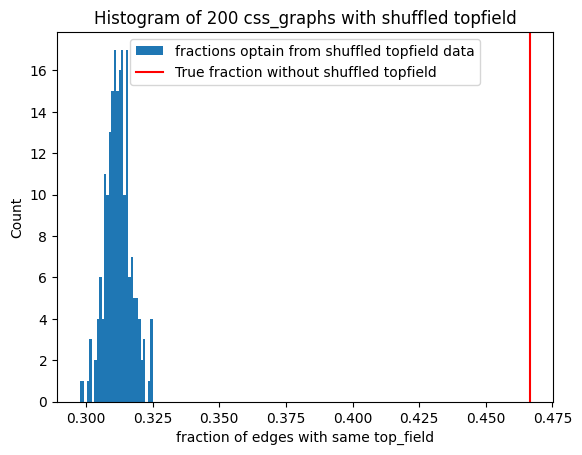

In [5]:
# Creates the histogram plot
fig, ax = plt.subplots()
ax.hist(neighbor_same_field_frac_shuffled_list, label='fractions optain from shuffled topfield data', bins=30)
ax.axvline(x=node_adj_same_field_frac,color='r',linestyle='-', label='True fraction without shuffled topfield')
ax.set_title('Histogram of 200 css_graphs with shuffled topfield')
ax.legend()
ax.set_xlabel('fraction of edges with same top_field')
ax.set_ylabel('Count')

# We then perform a permutation test using the data genereated in the above cell
t_obs = node_adj_same_field_frac
tq = np.mean(neighbor_same_field_frac_shuffled_list > node_adj_same_field_frac)

# calculate p value
p_value = tq
print(p_value)

# Compare the p-value to the significance level (e.g., 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis with p value: ", p_value)
else:
    print("Fail to reject the null hypothesis with p value: ", p_value)

After shuffling topfields 200 times and calculating the fraction of edges with nodes in the same topfield for each node. We get the following histogram. Where the red vertical line is the true fraction from the un-shuffled graph. We then performed a  permutation test. We get a p-value that is far below 0.05. Which means that we can conclude on a 0.05 significant level that the chance to connect to a member of the same field is statistically significantly higher than it would be by chance.

### 1.3 Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain?

assortativity coefficient with respect to author's field:  0.16561520729090562


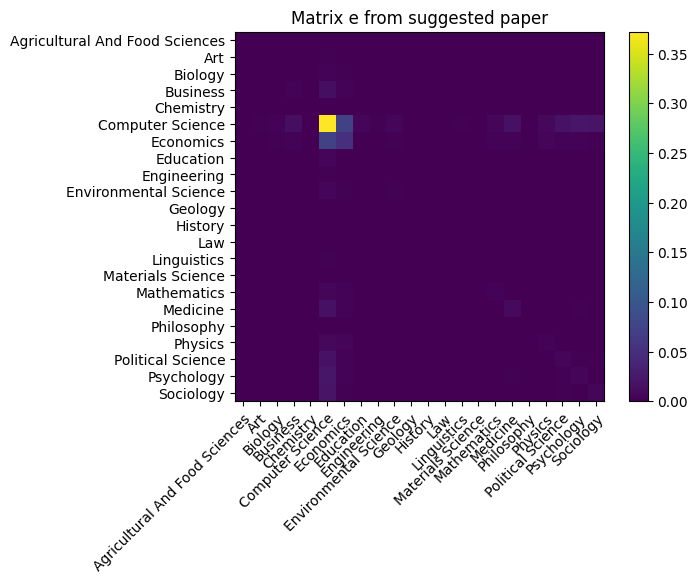

In [6]:
# extracts all unique 'top_field' values from the network G and stores them in a list called 'uniqe_top_fields
uniqe_top_fields = list(np.unique(list(node_fiels_dict.values())))
node_fiels_dict = nx.get_node_attributes(G,'top_field')

# creates a dictionary that maps each 'top_field' value to an index in the adjacency matrix 'e'.
uniqe_top_fields_mapping = {uniqe_top_fields[i]: i for i in range(len(uniqe_top_fields)) }
e = np.zeros((len(uniqe_top_fields),len(uniqe_top_fields)))

# Calcultes the matrix e from equation 2 in the recommended paper.
for node1, node2 in G.edges:
    node1_field = node_fiels_dict.get(node1)
    node1_field_index = uniqe_top_fields_mapping.get(node1_field)
    node2_field = node_fiels_dict.get(node2)
    node2_field_index = uniqe_top_fields_mapping.get(node2_field)

    # adds 1 to the total number of edges between these two fields
    e[node1_field_index, node2_field_index] += 1
    e[node2_field_index, node1_field_index] += 1

e /= (len(G.edges)*2)

# computes the assortativity coefficient
ass_coef = (np.trace(e) - np.sum(np.matmul(e,e))) / (1-np.sum(np.matmul(e,e)))
print("assortativity coefficient with respect to author's field: ", ass_coef)

# creates a plot to show the matrix e
fig, ax = plt.subplots()
im = ax.imshow(e)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(uniqe_top_fields)), labels=uniqe_top_fields)
ax.set_yticks(np.arange(len(uniqe_top_fields)), labels=uniqe_top_fields)
plt.title('Matrix e from suggested paper')
ax.figure.colorbar(im, ax=ax)


# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()

We calculate an assortativity coefficient with respect to author's field of 0.17. This implies that authors in the same fields are more likely to create papers together. However because the value is only 0.17 it means that authors does also regular create papers with authors in other fields.

We have furthermore plottet the matrix e from the suggested paper to visualise our calculation. We see that computer scientists dominate this field, and that they're most likely to work with other computer scientists. The highest amount of cross-disciplinary collaborations is between economists and computer scientists. This appears to between 10% and 5% of all edges, with the remaining cross-disciplinary fields  accounting for around 5% or less each. 

### 1.4 Is the graph assortative with respect to the degree? 

assortativity coefficient with respect to degree:  0.10593832920399461


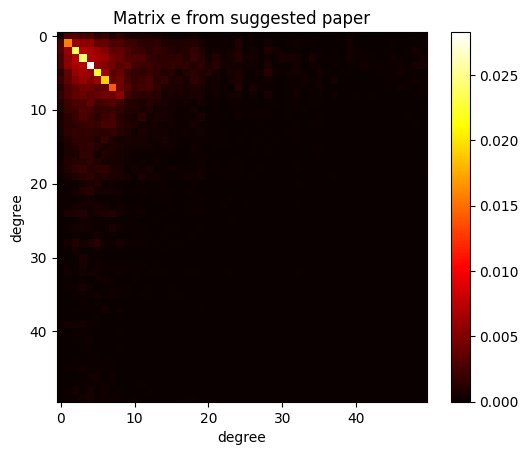

In [7]:
# extracts all unique 'degress' values from the network G and stores them in a list called 'uniqe_degrees
uniqe_degrees = list(np.unique(list(dict(G.degree()).values())))

# creates a dictionary that maps each 'top_field' value to an index in the adjacency matrix 'e'.
uniqe_degrees_mapping = {uniqe_degrees[i]: i for i in range(len(uniqe_degrees)) }
e = np.zeros((len(uniqe_degrees),len(uniqe_degrees)))

# Calcultes the matrix e from equation 2 in the recommended paper.
for node1, node2 in G.edges:
    node1_field = G.degree[node1]
    node1_field_index = uniqe_degrees_mapping.get(node1_field)
    node2_field = G.degree[node2]
    node2_field_index = uniqe_degrees_mapping.get(node2_field)

    # adds 1 to the total number of edges between these two fields
    e[node1_field_index, node2_field_index] += 1
    e[node2_field_index, node1_field_index] += 1

e /= len(G.edges)*2

# computes the assortativity coefficient
ass_coef = (np.trace(e) - np.sum(np.matmul(e,e))) / (1-np.sum(np.matmul(e,e)))
print("assortativity coefficient with respect to degree: ", ass_coef)

# creates a plot to show the matrix e
plt.plot()
plt.imshow(e, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xlabel('degree')
plt.ylabel('degree')
plt.title('Matrix e from suggested paper')
plt.show()

When calculating the assortativity coefficient with respect to degree we get a value of  0.11. Which implies that there is a trend towards same degree authors working together. Here degree being the number of other authors the author has worked with. 

From the graph of the matrix e. We can see that most authors has a degree between 0 and 10. We can also see that there are many links between authors who has similar but not exactly the same degree. Which implies that many authors that has a similar or same degree has worked together.

Depending on how one views this, this could be problematic in the sense that newcomers are less likely to be able to work with the highly regarded and influential CSS scientists. However, assortativity coefficient of degree is still lower than that of top field which implies that similar top field is a bigger factor when working together than degree.

### Optional: Estimate the gender of each author from their name, using the World Gender Name Dictionary. Repeat the analysis above to study the assortativity of the network by gender rather than by field. What do you observe?

assortativity coefficient with respect to gender:  0.04992537957602133


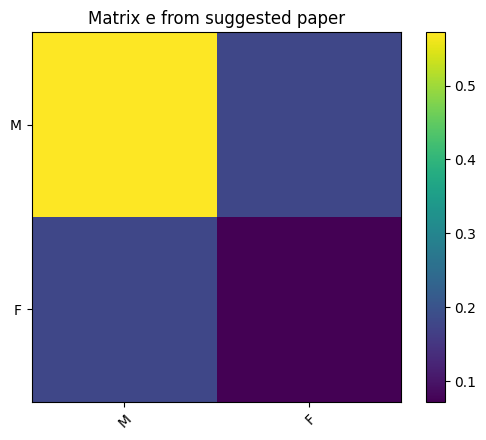

Gender count male, female:  [15169, 5049]


In [9]:
# We load the name to gender dataset from https://doi.org/10.7910/DVN/MSEGSJ
wgnd = pd.read_csv('/work/wgnd_2_0_name-gender_nocode.csv')
# converts it to a dictionary
wgnd_dict = wgnd.set_index('name')['gender'].to_dict()

# Get the names of all auhtors
node_names_dict = nx.get_node_attributes(G,'name')

# creates a dictionary that maps each gender  to an index in the adjacency matrix 'e'.
uniqe_genders = ["M","F"]
uniqe_genders_mapping = {uniqe_genders[i]: i for i in range(len(uniqe_genders)) }
e = np.zeros((len(uniqe_genders),len(uniqe_genders)))

gender_count = [0,0]
# Calcultes the matrix e from equation 2 in the recommended paper.
for node1, node2 in G.edges:
    # finds the gender using only first name
    node1_name = node_names_dict.get(node1)
    node1_gender = wgnd_dict.get(node1_name.split(' ')[0].strip().lower(),"NAME NOT FOUND")
    node1_gender_index = uniqe_genders_mapping.get(node1_gender, "NAME NOT FOUND")

    # finds the gender using only first name
    node2_name = node_names_dict.get(node2)
    node2_gender = wgnd_dict.get(node2_name.split(' ')[0].strip().lower(),"NAME NOT FOUND")
    node2_gender_index = uniqe_genders_mapping.get(node2_gender, "NAME NOT FOUND")
    

    # we ignore all links with first names we cant find the gender of
    if node1_gender != "NAME NOT FOUND" and node2_gender != "NAME NOT FOUND":
        e[node1_gender_index, node2_gender_index] += 1
        e[node2_gender_index, node1_gender_index] += 1

        # counts number of participants and their gender
        gender_count[node1_gender_index] += 1
        gender_count[node2_gender_index] += 1
    
e /= np.sum(np.sum(e))

# computes the assortativity coefficient
ass_coef = (np.trace(e) - np.sum(np.matmul(e,e))) / (1-np.sum(np.matmul(e,e)))
print("assortativity coefficient with respect to gender: ", ass_coef)

# creates a plot to show the matrix e
fig, ax = plt.subplots()
im = ax.imshow(e)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(uniqe_genders)), labels=uniqe_genders)
ax.set_yticks(np.arange(len(uniqe_genders)), labels=uniqe_genders)
plt.title('Matrix e from suggested paper')
ax.figure.colorbar(im, ax=ax)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()

print("Gender count male, female: ", gender_count)

Finally when calculating the assortativity coefficient with respect to gender we get a value of 0.05. This shows that gender is almost not correlated with authors collaboration. From the matrix e we can see that there are most links between men, this makes sense because there is about 3 times as many men as their are women in the dataset. 

# Part 2: Communities

> __Exercise 2: Zachary's karate club__: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html) 
>
> 1. Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.
>
> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.
> 3. Explain in your own words the concept of _modularity_. 
> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.
> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement the _double edge swap_ algorithm. The _double edge swap_ algorithm is quite old... it was implemented in 1891 (!) by Danish mathematician Julius Petersen(https://en.wikipedia.org/wiki/Julius_Petersen). Given a network G, this algorithm creates a new network, such that each node has exactly the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network.
>       * __b.__ Consider two edges in your new network (u,v) and (x,y), such that u!=v and v!=x.
>       * __c.__ If none of edges (u,y) and (x,v) exists already, add them to the network and remove edges (u,v) and (x,y).
>       * Repeat steps __b.__ and __c.__ to achieve at least N swaps (I suggest N to be larger than the number of edges).
> 6. Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.
> 7. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.
> 8. Compute the average and standard deviation of the modularity for the random network.
> 9. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 
> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?
> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?
> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

1. Visualize the graph using netwulf. Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.

In [10]:
KCG = nx.karate_club_graph()
community_header = np.unique([x for x in nx.get_node_attributes(KCG,'club').values()])
print(community_header)
## There's two different clubs, so let's color them using two colors:
for k, v in KCG.nodes(data=True):
    if v['club'] == 'Mr. Hi':
        v['color'] = 'red'
    else:
        v['color'] = 'blue'

#netwulf.visualize(KCG) ## Netwulf doesn't run on deepnote, but a picture is included of the one running locally

['Mr. Hi' 'Officer']


![](kcg.png)

2. Write a function to compute the modularity of a graph partitioning (use equation 9.12 in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [54]:
def compute_modularity(G, partition):
    modularity = 0
    community_header = np.unique([x for x in partition.values()]) ## List of unique communities
    for community in community_header:
        community_indices = [i for i, j in zip(partition.keys(), partition.values()) if j == community] ## Find indices of nodes in community
        Sg = G.subgraph(community_indices) ## Subgraph for community
        degreesum = sum([x for (y, x) in G.degree() if y in Sg]) ## Sum of degrees in subgraph
        modularity += len(Sg.edges)/len(G.edges) - ((degreesum/(2*len(G.edges)))**2) ## Inside of sum in eq (9.12)
    return modularity


3. Explain in your own words the concept of modularity.

>Modularity essentially measures how well we've divided our network into sub-modules, which we in our case call communities.


>It measures this by looking at the edges intra-community with edges going outside the community and comparing it with our modulation and a random graph. The higher the modularity, the more non-random our communities are, and therefore we assume them to be better defined. That is, if we could achieve the modulation from pure chance, it most likely is not a community.


4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a node attribute, called "club".

In [ ]:
print(compute_modularity(KCG, nx.get_node_attributes(KCG,'club')))



0.3582347140039447


5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement the _double edge swap_ algorithm. The _double edge swap_ algorithm is quite old... it was implemented in 1891 (!) by Danish mathematician Julius Petersen(https://en.wikipedia.org/wiki/Julius_Petersen). Given a network G, this algorithm creates a new network, such that each node has exactly the same degree as in the original network, but different connections. Here is how the algorithm works.
       * __a.__ Create an identical copy of your original network.
       * __b.__ Consider two edges in your new network (u,v) and (x,y), such that u!=v and v!=x.
       * __c.__ If none of edges (u,y) and (x,v) exists already, add them to the network and remove edges (u,v) and (x,y).
       * Repeat steps __b.__ and __c.__ to achieve at least N swaps (I suggest N to be larger than the number of edges).

In [12]:
def double_edge_swap(G, N):
    ## Step a) create an identical copy of the network
    Gc = G.copy()
    swaps = 0
    ## Step b) consider two edges (u,v) (x,y) u!=v x!=y
    while swaps < N:
        eidx1, eidx2 = np.random.choice(range(len(Gc.edges())), 2, replace=False)
        e1 = [(a, b) for (a, b) in Gc.edges()][eidx1]
        e2 = [(a, b) for (a, b) in Gc.edges()][eidx2]
        # x, y = np.random.choice(range(len(Gc.edges())), 2, replace=False)
        # u, v = np.random.choice(range(len(Gc.edges())), 2, replace=False)
        ## Step c) if none of edges (u,y) and (x,v) exist already, add them to the network and remove (u,v) and (x,y)
        if (e1[0], e2[1]) not in nx.edges(Gc, [e1[0]]) and (e2[0], e1[1]) not in nx.edges(Gc, [e2[0]]):
            Gc.add_edge(e1[0], e2[1])
            Gc.add_edge(e2[0], e1[1])
            Gc.remove_edge(e1[0], e1[1])
            Gc.remove_edge(e2[0], e2[1])
            swaps += 2
    return Gc


6. Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

In [13]:
KCG.degree()

KCGc = double_edge_swap(KCG, 100)

In [14]:
assert([x for x in KCG.degree()] == [x for x in KCGc.degree()])
print(KCG.edges())
print(KCGc.edges())

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]
[(0, 3), (0, 7), (0, 12), (0, 17), (0, 19), (0, 21), (0, 9), (0, 25), (0, 31), (0, 27), (0, 14), (0, 10), (0, 28), (0, 24), (0, 33), (0, 23), (1, 13), (1, 10), (1, 31), (1, 8), (1, 2), (1, 28), (1, 32), (1, 4), (1, 23), (2, 32), (2, 33), (2, 30), (2, 2), (2, 3), (2, 13), (2, 29), (

7. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [15]:

modularities=[]
for i in range(1000):
    KCG_temp = double_edge_swap(KCG, 100)
    modularities.append(compute_modularity(KCG_temp, nx.get_node_attributes(KCG_temp,'club')))

print(modularities)

[0.10182445759368833, -0.0007396449704142605, -0.02638067061143992, -0.02638067061143992, -0.0007396449704142605, 0.050542406311637006, -0.02638067061143992, 0.07618343195266267, 0.07618343195266267, -0.02638067061143992, 0.024901380670611373, 0.024901380670611373, 0.050542406311637006, 0.024901380670611373, 0.024901380670611373, 0.050542406311637006, 0.050542406311637006, -0.02638067061143992, 0.024901380670611373, 0.024901380670611373, 0.07618343195266267, 0.024901380670611373, 0.024901380670611373, 0.12746548323471393, 0.07618343195266267, 0.050542406311637006, -0.0007396449704142605, 0.10182445759368833, 0.024901380670611373, -0.02638067061143992, 0.050542406311637006, 0.050542406311637006, -0.0007396449704142605, 0.050542406311637006, 0.10182445759368833, 0.10182445759368833, 0.07618343195266267, 0.024901380670611373, 0.07618343195266267, -0.0007396449704142605, 0.07618343195266267, -0.02638067061143992, 0.07618343195266267, 0.050542406311637006, 0.07618343195266267, 0.10182445759

8. Compute the average and standard deviation of the modularity for the random network.

In [16]:
mean = np.mean(modularities)
sd = np.std(modularities)
median = np.median(modularities)
maxm = max(modularities)
print("mu: "+str(mean)+" sigma: "+str(sd))
print("median: "+ str(median))
print("max: " + str(maxm))


mu: 0.03171129877448552 sigma: 0.0446435194564539
median: 0.024901380670611373
max: 0.20438856015779086


9. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 

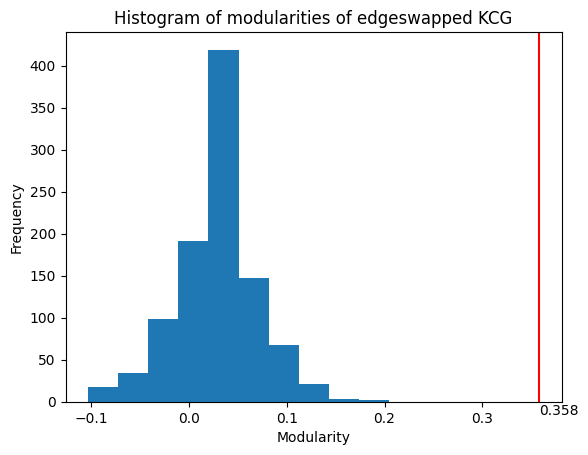

In [20]:
plt.hist(modularities)
plt.axvline(compute_modularity(KCG, nx.get_node_attributes(KCG,'club')), c='r')
# plt.axvline(mean, c='black')
# plt.axvline(median, c='b')
plt.text((compute_modularity(KCG, nx.get_node_attributes(KCG,'club'))), -15, str(np.round(compute_modularity(KCG, nx.get_node_attributes(KCG,'club')),3)))
plt.xlabel("Modularity")
plt.ylabel("Frequency")
plt.title("Histogram of modularities of edgeswapped KCG")
plt.show()


10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

>The figure shows that the modularities of the randomized graphs are distributed in a bell shape, with the most frequent modularities being around 0.02, not going much above 0.2. The red line to the right shows the modularity of the club split, 0.358. Interestingly enough, we see that the modularities do not have a mean of zero, as the distributions center is shifted towards the right to how we would expect it to be if it was completely random. If it was completely randomized, the negative part of the sum in equation (9.12), that accounts for the expected modularity if the groups were randomized, would drive the distribution center to be a lot closer to 0. It is probably the case that running the algorithm 100 times is not enough or too many for it to be properly randomized.
>The club split is a good partition, as none of the randomizations produced a split with close to or greater modularity than that of the club split. The randomization experiment was done to highlight that the modularity of the club split was high, and to put the number in perspective when comparing to random partitions. The node degree is preserved when using the double swap algorithm as each vertex considered in step b) has one edge removed and another added.

11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [21]:
import community
bp = community.best_partition(KCG)
compute_modularity(KCG, bp)

0.41978961209730437

> The modularity of the Louvain-algorithm partition is 0.42, which is greater than the modularity of the club split of 0.358. This shows that there is a better way of partitioning the nodes than the club split. 

12. Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [22]:
A = len(np.unique([x for x in bp.values()]))
clubp = nx.get_node_attributes(KCG,'club')
community_header = np.unique([x for x in clubp.values()])

for i, value in enumerate(clubp.values()):
    if value == "Mr. Hi":
        clubp[i] = 0
    else:
        clubp[i] = 1

# community_indices = [i for i, j in enumerate(partition.values()) if j == community]
D = np.zeros((A, 2))
for i in range(A):
    lkv = [k for (k, v) in zip(bp.keys(), bp.values()) if v == i]
    for j in range (2):
        ckv = [k for (k, v) in zip(clubp.keys(), clubp.values()) if v == j]
        D[i, j] = len([x for x in lkv if x in ckv])

print(D)


[[11.  0.]
 [ 0.  6.]
 [ 5.  0.]
 [ 1. 11.]]


> We can see from D that the Louvain algorithm finds a subdivision of the club split with almost no overlap between the club division, that is, only one "Mr. Hi" is in one of the two groups otherwise consisting solely of "Officer", while no "Officer" is found in the two groups with only "Mr. Hi". Therefore, the original club split was alike the louvain split, but a further subdivision would yield a better partitioning.

> __Exercise 3__: Community detection on the network of Computational Social Scientists. 
>
> * Consider the network you built in [Week 4](https://github.com/lalessan/comsocsci2023/blob/main/lectures/Week4.ipynb).
> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 
> * If you are curious, you can also try the *Infomap* algorithm. Go to [this page]. (https://mapequation.github.io/infomap/python/). It's harder to install, but a better community detection algorithm. You can read about it in [advanced topics 9B](http://networksciencebook.com/chapter/9#advanced-9b).
> * Visualize the network, using netwulf (see Week 5). This time assign each node a different color based on their _community_. Describe the structure you observe.
> * Make sure you save the assignment of authors to communities. 


1. Consider the network you built in Week 4.
2. Use the Python Louvain-algorithm implementation to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0?

In [56]:
import community
G = G.copy()
nx.relabel_nodes(G, dict(zip(G, range(G.number_of_nodes()))))
## Need to relabel for later use

bpcss = community.best_partition(G)

69 unique communities are found
{0: 14, 1: 195, 2: 200, 3: 124, 4: 91, 5: 278, 6: 58, 7: 378, 8: 147, 9: 134, 10: 36, 11: 69, 12: 157, 13: 23, 14: 102, 15: 260, 16: 29, 17: 85, 18: 82, 19: 51, 20: 149, 21: 70, 22: 15, 23: 55, 24: 175, 25: 48, 26: 75, 27: 25, 28: 43, 29: 78, 30: 156, 31: 137, 32: 32, 33: 84, 34: 42, 35: 67, 36: 53, 37: 149, 38: 60, 39: 54, 40: 32, 41: 101, 42: 117, 43: 122, 44: 101, 45: 28, 46: 87, 47: 197, 48: 11, 49: 11, 50: 76, 51: 17, 52: 120, 53: 30, 54: 55, 55: 121, 56: 5, 57: 53, 58: 34, 59: 22, 60: 22, 61: 31, 62: 28, 63: 8, 64: 43, 65: 58, 66: 9, 67: 21, 68: 26}
Modularity: 0.8714035719381688
Median: 58.0


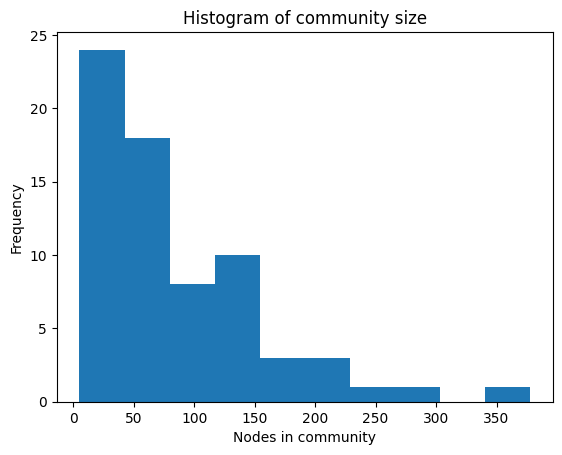

In [52]:
com = np.unique(list(bpcss.values()))
ncom = len(com)
nincom = {x: len([k for (k, v) in zip(bpcss.keys(), bpcss.values()) if v == x]) for x in com}

print(str(ncom) + " unique communities are found")
print(nincom)
print("Modularity: " + str(compute_modularity(G, bpcss)))
print("Median: " + str(np.median([x for x in nincom.values()])))

# plt.scatter([y for y in nincom.keys()], [x for x in nincom.values()])
# plt.xlabel("Community")
# plt.ylabel("Number of nodes")
# plt.title("Plot of number of nodes in community")
# plt.show()

plt.hist([x for x in nincom.values()])
plt.xlabel("Nodes in community")
plt.ylabel("Frequency")
plt.title("Histogram of community size")
plt.show()

> 69 unique communities are found, and the sizes range from a couple of nodes to just under 350. Only a few large communities exist, whereas the majority of communities has around 60 nodes or less. The modularity is computed to be 0.871. We could test it against random double edge swaps of the network, but based on our previous findings it would not seem that this would truly test for a significant difference in modularity from 0, but rather some number tied to the amount of times the double swap algorithm was applied.

> Researching this, it would seem that a configuration model of the network would be more suitable. This is the same idea as in the double swap algorithm, but cuts every edge in the graph and reconnects them randomly, even with a possibility of connecting a node to itself or having parallel edges, which doesn't make much sense from the definition of our network (an author collaborating with themselves or collaborating twice with someone else). However, this makes more sense from a stistical point of view, as limiting a randomization of a graph where some nodes have a lot of edges to not include self-loops and parallel edges will make the randomization much less random. As we use this for a statistic test, the fidelity of the graph is less important than a correct measure. Thus, we will do a permutation test using the configuration model setup.

In [ ]:
modularities=[]
for i in range(1000):
    conf = nx.configuration_model([x for _, x in G.degree()])
    conf = nx.Graph(conf)
    modularities.append(compute_modularity(conf, bpcss))



In [ ]:
mean = np.mean(modularities)
sd = np.std(modularities)
median = np.median(modularities)
minm = min(modularities)
maxm = max(modularities)
print("mu: "+str(mean)+" sigma: "+str(sd))
print("median: "+ str(median))
print("min: " + str(minm))
print("max: " + str(maxm))


mu: 0.0 sigma: 0.0
median: 0.0
min: 0.0
max: 0.0


> We see that every computed modularity becomes 0, probably due to the large number of nodes and edges in the graph, which allows for many combinations of edges. We can test this by seeing if the modularity computed on a configuration model of the KCG network with a configuration model is any different:

mu: 0.0006813648821539284 sigma: 0.0545225725059872
median: -0.0003858024691357209
max: 0.18455620191405506


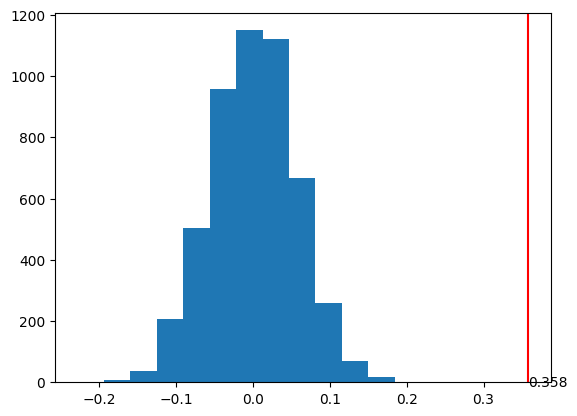

In [ ]:
cmodularities=[]
for i in range(5000):
    conf = nx.configuration_model([x for _, x in KCG.degree()])
    conf = nx.Graph(conf)
    cmodularities.append(compute_modularity(conf, nx.get_node_attributes(KCG,'club')))

cmean = np.mean(cmodularities)
csd = np.std(cmodularities)
cmedian = np.median(cmodularities)
cmaxm = max(cmodularities)
print("mu: "+str(cmean)+" sigma: "+str(csd))
print("median: "+ str(cmedian))
print("max: " + str(cmaxm))

plt.hist(cmodularities, bins=12)
plt.axvline(compute_modularity(KCG, nx.get_node_attributes(KCG,'club')), c='r')
# plt.axvline(mean, c='black')
# plt.axvline(median, c='b')
plt.text((compute_modularity(KCG, nx.get_node_attributes(KCG,'club'))), -15, str(np.round(compute_modularity(KCG, nx.get_node_attributes(KCG,'club')),3)))
plt.show()


> Which looks to be the case. We probably don't need to do a statistical test now, but it is done for good measure.

> Our null hypothesis is that the modularity is 0, or rather, that our sample modularity is drawn from the same distribution as one which has a theoretical modularity of 0. We set our significance level to $\alpha=5\%$, meaning that in 5% of cases we will reject the null hypothesis even though it is true. We set $t_{obs}$ to the modularity we have computed on the louvain partition of our network, and $t_{0}$ to the modularity of the $N=1000$ configuration models that we have sampled.

In [ ]:
t_obs = compute_modularity(G, bpcss)
tq = len([x for x in modularities if x > t_obs])/len(modularities)

pval = tq*2
print(pval)

0.0


> We get $p=0$ and therefore we reject the null hypothesis that the modularity is 0.

3. Visualize the network, using netwulf (see Week 5). This time assign each node a different color based on their _community_. Describe the structure you observe.
4. Make sure you save the assignment of authors to communities. 

In [ ]:
G_louvain = G.copy()

In [ ]:
for k, v in G_louvain.nodes(data=True):
    ## Set group to community
    v['group']= bpcss[k]
    ## Set size to median citation count
    if v.get('median_Citation_Count', 0) != 0:
        v['size'] = v['median_Citation_Count']
    else:
        v['size'] = 1

> The visualization is made on a local computer as Deepnote doesn't allow for hosting web services

In [ ]:
netwulf.interactive.visualize(G, verbose=True)

![](networklouvain.png)

> In the above graph, the size is both proportional to median citation count as well as the amount of collaborators.

> Many of the communities have clear overlaps with single nodes from other communities. This seems to be especially true for larger nodes (those with higher citation count and more collaborators). It seems to often be the case that the authors that collaborate with many people collaborate across communities, while authors that collaborate with fewer people usually collaborate within the same community of authors. From the visualization, the high modularity is a bit surprising, but we need to keep in mind that the netwulf graph is based on physics simulation to handle large graphs, and that changing the size of the nodes has an impact on how neat the visualization is.

# Part 3: TF-IDF.


> __Exercise 4: TF-IDF and the Computational Social Science communities.__ The goal for this exercise is to find the words charachterizing each of the communities of Computational Social Scientists.
> What you ned for this exercise: 
>    * The assignment of each author to their network community, and the degree of each author (Week 6, Exercise 4). This can be stored in a dataframe or in two dictionaries, as you prefer.  
>    * the tokenized _abstract_ dataframe (Week 7, Exercise 2)
>
> 1. First, check out [the wikipedia page for TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Explain in your own words the point of TF-IDF. 
>   * What does TF stand for? 
>   * What does IDF stand for?
> 2. Now, we want to find out which words are important for each *community*, so we're going to create several ***large documents, one for each community***. Each document includes all the tokens of abstracts written by members of a given community. 
>   * Consider a community _c_
>   * Find all the abstracts of papers written by a member of community _c_.
>   * Create a long array that stores all the abstract tokens 
>   * Repeat for all the communities. 
> __Note:__ Here, to ensure your code is efficient, you shall exploit ``pandas`` builtin functions, such as [``groupby.apply``](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.apply.html) or [``explode``](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html).
> 3. Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within the __top 5 communities__ (by number of authors). 
>   * Describe similarities and differences between the communities.
>   * Why aren't the TFs not necessarily a good description of the communities?
>   * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?
> 4. We're ready to calculate TF-IDF. Do that for the __top 9 communities__ (by number of authors). Then for each community: 
>   * List the 10 top TF words 
>   * List the 10 top TF-IDF words
>   * List the top 3 authors (by degree)
>   * Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?


> __Exercise 5: The Wordcloud__. It's time to visualize our results!
> * Install the [`WordCloud`](https://pypi.org/project/wordcloud/) module. 
> * Now, create word-cloud for each community. Feel free to make it as fancy or non-fancy as you like.
> * Make sure that, together with the word cloud, you print the names of the top three authors in each community (see my plot above for inspiration). 
> * Comment on your results. What can you conclude on the different sub-communities in Computational Social Science? 
> * Look up online the top author in each community. In light of your search, do your results make sense?

1. First, check out the wikipedia page for TF-IDF. Explain in your own words the point of TF-IDF.
a) What does TF stand for?
b)What does IDF stand for?

a) It stands for Term Frequency
b) It stands for Inverse Document Frequency

Essentially, the purpose of TF-IDF is to figure out what a given document has information about. As the example in the Wikiepdia article states, it might be, that we're looking for documents that tell us something about "brown cows". 

If we therefore run through each document and note how many times a word appears, we can assume that the more a word appears in article relative to the number of words in that article, the more the article is about that word. F.ex, if we have a bunch of documents from Yahoo News, and we want to research what happened to the Theranos case, documents with a high frequencies of the words "Elizabeth","Holmes" and "Theranos" probably are probably mainly about the Theranos case.

Of course, there is a caveat to this; there are a lot of words with very little information, that appear often. As an example the words "a","an", "the" and so on appear very often however, they tell us nothing about the contents of a document. We therefore have to weight our TF's with the IDF, such that words that appear in all documents - and therefore do not help us distinguish what information are in the individual documents - are as close to 0 as possible.

3

In [ ]:
fig = plt.figure(figsize=(22,22))
plt.rcParams['text.usetex'] = False

for idx,bigTenTuple in enumerate(bigTen):
        #print(f"Community: {bigTenTuple[0]}: {[authorTuple[2] for authorTuple in topThreeAuthors[idx]]}")
        wordcloud = wordClouds[idx]
        #plt.imshow(wordcloud, interpolation='bilinear')
        #plt.axis("off")

        # lower max_font_size
        plt.subplot(4,4,idx+1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        newline = ' \n'

        plt.title('Community: ' +str(bigTenTuple[0]) + ' \n ' +''.join([str(authorTuple[2]) + newline  for authorTuple in topThreeAuthors[idx]]))
        #print("Community: " + str(bigTenTuple[0]) + ' \n ' + ''.join([str(authorTuple[2]) + newline  for authorTuple in topThreeAuthors[idx]]))


plt.subplots_adjust(wspace=.2, hspace=-.5,top=1)
fig.suptitle('Wordclouds for the top 10 communities', fontsize=24)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2916efa0-c445-43ca-8dcd-0a1bcdbbd016' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>